# **BANK OF AMERICA**

# Installation of the packages 



In [138]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [139]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib as mpl

import scipy.stats as si


## Download of the data from Yahoo Finance API

In [140]:
initial_data = yf.download(" BAC ", start="2020-03-01", end="2021-03-01")

[*********************100%***********************]  1 of 1 completed


In [197]:
data=initial_data['Adj Close']
data.describe()

count    251.000000
mean      25.696392
std        3.752451
min       17.632553
25%       23.288668
50%       24.649536
75%       28.225950
max       36.200199
Name: Adj Close, dtype: float64

## Stock price plot

array([<AxesSubplot:xlabel='Date'>], dtype=object)

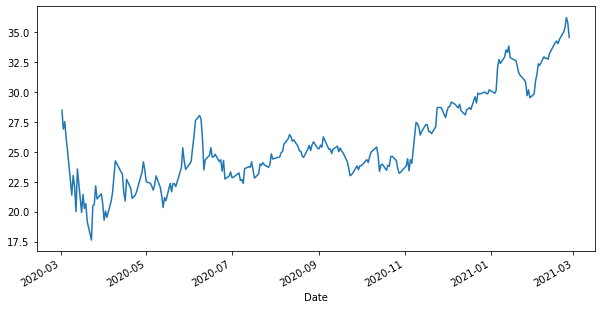

In [142]:
data.plot(figsize=(10, 5), subplots=True)

## Daily Log returns for 12 months period of data
### To calculate the Annualised Mean Return and the implied volatility 

In [143]:
rets_12M = np.log(data / data.shift(1)) #Daily log return

MeanDReturn_12M = rets_12M.mean()
Ann_DRet_12M = MeanDReturn_12M*252
Ann_DRet_12M #Annualised Mean Return

0.19506752587696466

In [144]:
rets_12M.std() 
AnnStd_12=float(rets_12M.std())  #Standard deviation
AnnStd_12

0.03709234072804379

In [544]:
import math

AnnVol_12M = AnnStd_12*math.sqrt(252) #Annualised Volatility
AnnVol_12M

0.5888226546700583

## Download 6 month data to compare volatility 

In [146]:
initial_data2 = yf.download(" BAC ", start="2020-09-01", end="2021-03-01")

[*********************100%***********************]  1 of 1 completed


In [364]:
initial_data2['Adj Close'].tail()

Date
2021-02-22    34.976276
2021-02-23    35.344448
2021-02-24    36.200199
2021-02-25    35.752422
2021-02-26    34.538448
Name: Adj Close, dtype: float64

In [147]:
data2=initial_data2['Adj Close']
data6M=initial_data2['Adj Close']
data6M.describe()

count    124.000000
mean      28.058672
std        3.646040
min       23.001680
25%       24.660551
50%       28.225950
75%       30.809473
max       36.200199
Name: Adj Close, dtype: float64

array([<AxesSubplot:xlabel='Date'>], dtype=object)

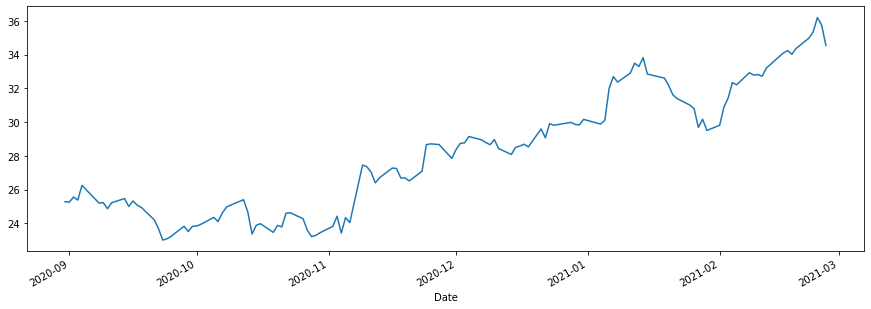

In [365]:
data6M.plot(figsize=(15, 5), subplots=True)

### Daily return and Implied volatility for 6 Months 

In [149]:
rets_6M = np.log(data2/ data2.shift(1)) #Daily log return

MeanDReturn_6M = rets_6M.mean()
Ann_DRet_6M = MeanDReturn_6M*252
Ann_DRet_6M #Annualised Mean Return

0.6394996598582823

In [150]:
rets_6M.std() 
AnnStd_6=float(rets_6M.std())  #Standard deviation
AnnStd_6

0.02277928845762163

In [151]:
AnnVol_6M = AnnStd_6*math.sqrt(252) #Annualised Volatility
AnnVol_6M

0.36160999381122555

# Analysis of the option value 

## Binomial Tree

In [152]:
import numpy as np
import os

In [550]:
S0 = 34.53              # spot stock price
K = 32.80              # strike
T = 1/12                # maturity 
r = 0.0167              # risk free rate 
sig = 0.3616            # volatility (6M, in order to exclude noise from COVID Crash)
N = 4                   # number of periods or number of time steps  
payoff = "put"          # payoff

In [551]:
dT = float(T) / N                             # Delta t
u = np.exp(sig * np.sqrt(dT))                 # up factor
d = 1.0 / u                                   # down factor

In [552]:
S = np.zeros((N + 1, N + 1))
S[0, 0] = S0
z = 1
for t in range(1, N + 1):
    for i in range(z):
        S[i, t] = S[i, t-1] * u
        S[i+1, t] = S[i, t-1] * d
    z += 1

In [553]:
S

array([[34.53      , 36.38006558, 38.3292549 , 40.38287885, 42.5465329 ],
       [ 0.        , 32.77401734, 34.53      , 36.38006558, 38.3292549 ],
       [ 0.        ,  0.        , 31.10733311, 32.77401734, 34.53      ],
       [ 0.        ,  0.        ,  0.        , 29.52540616, 31.10733311],
       [ 0.        ,  0.        ,  0.        ,  0.        , 28.02392625]])

In [554]:
a = np.exp(r * dT)    # risk free compound return
p = (a - d)/ (u - d)  # risk neutral up probability
q = 1.0 - p           # risk neutral down probability
p

0.4902869282420304

### Possible outcomes of the option:

In [555]:
#PAYOFF IN PUT: K-S,0
S_T = S[:,-1]
S_T

array([42.5465329 , 38.3292549 , 34.53      , 31.10733311, 28.02392625])

### Pay-off of the *put* option:

In [556]:
S_T = S[:,-1]
V = np.zeros((N + 1, N + 1))
if payoff =="call":
    V[:,-1] = np.maximum(S_T-K, 0.0)
elif payoff =="put":
    V[:,-1] = np.maximum(K-S_T, 0.0) #-----Pay-off in the last column
V

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 1.69266689],
       [0.        , 0.        , 0.        , 0.        , 4.77607375]])

In [373]:
# for European Option
for j in range(N-1, -1, -1):
    for i in range(j+1):
        V[i,j] = np.exp(-r*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1])
V

array([[0.76092623, 0.22392136, 0.        , 0.        , 0.        ],
       [0.        , 1.27798429, 0.43946151, 0.        , 0.        ],
       [0.        , 0.        , 2.08542183, 0.86247432, 0.        ],
       [0.        , 0.        , 0.        , 3.26318416, 1.69266689],
       [0.        , 0.        , 0.        , 0.        , 4.77607375]])

In [374]:
print('European ' + payoff, str( V[0,0]))

European put 0.7609262278683082


In [375]:

# for American Option
if payoff =="call":
    for j in range(N-1, -1, -1):
        for i in range(j+1):
            V[i,j] = np.maximum(S[i,j] - K,np.exp(-r*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1]))
elif payoff =="put":
    for j in range(N-1, -1, -1):
        for i in range(j+1):
            V[i,j] = np.maximum(K - S[i,j],np.exp(-r*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1]))
V

array([[0.7624356 , 0.22392136, 0.        , 0.        , 0.        ],
       [0.        , 1.28094655, 0.43946151, 0.        , 0.        ],
       [0.        , 0.        , 2.09123547, 0.86247432, 0.        ],
       [0.        , 0.        , 0.        , 3.27459384, 1.69266689],
       [0.        , 0.        , 0.        , 0.        , 4.77607375]])

In [376]:
print('American ' + payoff, str( V[0,0]))

American put 0.7624356042491041


## Monte Carlo Simulation

In [404]:
#Monte Carlo Simulation

def mcs_simulation_np(p):
    M = p
    I = p
    dt = T / M 
    S = np.zeros((M + 1, I))
    S[0] = S0 
    rn = np.random.standard_normal(S.shape) 
    for t in range(1, M + 1): 
        S[t] = S[t-1] * np.exp((r - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * rn[t]) 
    return S

In [405]:


S0 = 34.53              # spot stock price
K = 32.80               # strike
T = 1/12                # maturity 
r = 0.0167              # risk free rate 
sigma = 0.3616            # volatility (6M, in order to exclude noise from COVID Crash)
N = 4                   # number of periods or number of time steps  
payoff = "put"          # payoff

In [406]:
S = mcs_simulation_np(10000)
S

array([[34.53      , 34.53      , 34.53      , ..., 34.53      ,
        34.53      , 34.53      ],
       [34.54919186, 34.51576286, 34.51746404, ..., 34.57373725,
        34.5095005 , 34.50769837],
       [34.54493575, 34.49170072, 34.44268987, ..., 34.57626678,
        34.53981071, 34.58930169],
       ...,
       [36.9499144 , 33.10669801, 38.9009685 , ..., 37.71551482,
        33.41031545, 28.763194  ],
       [36.93429569, 33.09096463, 38.82574804, ..., 37.65423819,
        33.44337534, 28.78996958],
       [36.87638224, 33.07382247, 38.82055092, ..., 37.65990209,
        33.46233883, 28.78452648]])

In [407]:
S = np.transpose(S)
S

array([[34.53      , 34.54919186, 34.54493575, ..., 36.9499144 ,
        36.93429569, 36.87638224],
       [34.53      , 34.51576286, 34.49170072, ..., 33.10669801,
        33.09096463, 33.07382247],
       [34.53      , 34.51746404, 34.44268987, ..., 38.9009685 ,
        38.82574804, 38.82055092],
       ...,
       [34.53      , 34.57373725, 34.57626678, ..., 37.71551482,
        37.65423819, 37.65990209],
       [34.53      , 34.5095005 , 34.53981071, ..., 33.41031545,
        33.44337534, 33.46233883],
       [34.53      , 34.50769837, 34.58930169, ..., 28.763194  ,
        28.78996958, 28.78452648]])

### Price distribution of the underlying stock

Text(0.5, 1.0, 'Frequency distribution of the simulated end-of-preiod values')

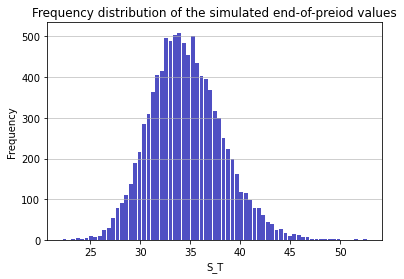

In [408]:
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(x=S[:,-1], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('S_T')
plt.ylabel('Frequency')
plt.title('Frequency distribution of the simulated end-of-preiod values')

### Pricing value through Monte Carlo 

In [383]:
p = np.mean(np.maximum(K - S[:,-1],0))
print('European put', str(p))

#Takes maximum value compared to zero, the result is the average of the results.

European put 0.673625012352794


## Black Scholes Model 

In [385]:

#Black-Scholes model
import matplotlib.pyplot as plt
S = 34.53              # spot stock price
K = 32.80               # strike
T = 1/12                # maturity 
r = 0.0167              # risk free rate 
sigma = 0.3616          
q = 0.0186              #dividend rate
N = 4  
payoff = "put"

In [386]:
def euro_option_bsm(S, K, T, r, q, vol, payoff):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: risk free rate
    #q: continuous dividend yield
    #vol: volatility of underlying asset
    #payoff: call or put
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        option_value = S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        option_value =  - S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) + K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return option_value

In [387]:
euro_option_bsm(34.53, 32.8, 1/12, 0.0167, 0.0186, 0.3616, 'put')

0.7032532397065108

## PRICING WITH MIBIAN

In [195]:
BAC = yf.Ticker("BAC")
opt = BAC.option_chain('2021-04-01')
opt.puts

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,BAC210401P00026500,2021-03-05 16:30:48,26.5,0.06,0.00,0.08,0.00,0.000000,40,400,1.554690,False,REGULAR,USD
1,BAC210401P00027000,2021-03-19 13:30:11,27.0,0.01,0.00,0.03,0.00,0.000000,1,26,1.296879,False,REGULAR,USD
2,BAC210401P00027500,2021-03-08 18:20:48,27.5,0.02,0.00,0.03,0.00,0.000000,4,283,1.250004,False,REGULAR,USD
3,BAC210401P00028000,2021-03-08 19:31:48,28.0,0.02,0.00,0.01,0.00,0.000000,3,45,1.031255,False,REGULAR,USD
4,BAC210401P00028500,2021-03-10 14:30:01,28.5,0.01,0.00,0.03,0.00,0.000000,2,22,1.125004,False,REGULAR,USD
5,BAC210401P00029000,2021-03-24 14:24:43,29.0,0.01,0.00,0.03,0.00,0.000000,149,172,1.062505,False,REGULAR,USD
6,BAC210401P00029500,2021-03-16 15:18:48,29.5,0.02,0.00,0.03,0.00,0.000000,2,10,1.015630,False,REGULAR,USD
7,BAC210401P00030000,2021-03-24 14:23:47,30.0,0.01,0.00,0.03,0.00,0.000000,84,666,0.953125,False,REGULAR,USD
8,BAC210401P00030500,2021-03-18 16:52:33,30.5,0.01,0.00,0.03,0.00,0.000000,1,67,0.906251,False,REGULAR,USD
9,BAC210401P00031000,2021-03-26 19:58:00,31.0,0.01,0.00,0.03,-0.01,-50.000000,40,782,0.843752,False,REGULAR,USD


In [393]:

K = opt.puts['strike']


In [201]:
pip install mibian

Note: you may need to restart the kernel to use updated packages.


In [202]:
import mibian as mb
S=initial_data['Adj Close'][-1]

In [388]:
option_100d = mb.Me([S, 32.8, 0.0167*100, 0.0186*100, 31], volatility = 0.3505*100)

In [389]:
option_100d.putPrice

0.7072111510366206

In [395]:
BAC_mb_bsm_put = np.zeros((len(K),1))
for i in range(len(K)):
    BAC_mb_bsm_put  [i] = mb.Me([S, K[i], 0.0167*100, 0.0186*100, 31], volatility = 0.3616*100).putPrice

In [396]:
opt.puts['MB_BSMPrice'] = pd.DataFrame(BAC_mb_bsm_put)
opt.puts

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,MB_BSMPrice,estimate_error_mb
0,BAC210401P00026500,2021-03-05 16:30:48,26.5,0.06,0.00,0.08,0.00,0.000000,40,400,1.554690,False,REGULAR,USD,0.006732,-97.886343
1,BAC210401P00027000,2021-03-19 13:30:11,27.0,0.01,0.00,0.03,0.00,0.000000,1,26,1.296879,False,REGULAR,USD,0.011585,-99.647724
2,BAC210401P00027500,2021-03-08 18:20:48,27.5,0.02,0.00,0.03,0.00,0.000000,4,283,1.250004,False,REGULAR,USD,0.019236,-99.295448
3,BAC210401P00028000,2021-03-08 19:31:48,28.0,0.02,0.00,0.01,0.00,0.000000,3,45,1.031255,False,REGULAR,USD,0.030884,-99.295448
4,BAC210401P00028500,2021-03-10 14:30:01,28.5,0.01,0.00,0.03,0.00,0.000000,2,22,1.125004,False,REGULAR,USD,0.048043,-99.647724
5,BAC210401P00029000,2021-03-24 14:24:43,29.0,0.01,0.00,0.03,0.00,0.000000,149,172,1.062505,False,REGULAR,USD,0.072542,-99.647724
6,BAC210401P00029500,2021-03-16 15:18:48,29.5,0.02,0.00,0.03,0.00,0.000000,2,10,1.015630,False,REGULAR,USD,0.106511,-99.295448
7,BAC210401P00030000,2021-03-24 14:23:47,30.0,0.01,0.00,0.03,0.00,0.000000,84,666,0.953125,False,REGULAR,USD,0.152328,-99.647724
8,BAC210401P00030500,2021-03-18 16:52:33,30.5,0.01,0.00,0.03,0.00,0.000000,1,67,0.906251,False,REGULAR,USD,0.212541,-99.647724
9,BAC210401P00031000,2021-03-26 19:58:00,31.0,0.01,0.00,0.03,-0.01,-50.000000,40,782,0.843752,False,REGULAR,USD,0.289763,-99.647724


In [397]:
opt.puts['estimate_error_mb'] = ((opt.puts['lastPrice'] - opt.puts['MB_BSMPrice'])/opt.puts['MB_BSMPrice'])*100
opt.puts['estimate_error_mb']

0     791.282265
1     -13.678603
2       3.972267
3     -35.242591
4     -79.185169
5     -86.214816
6     -81.222577
7     -93.435223
8     -95.295018
9     -96.548903
10    -92.239168
11    -96.041994
12    -96.914023
13    -98.775412
14    -98.023766
15    -98.380608
16    -97.980793
17    -97.732052
18    -97.582275
19    -97.080246
20    -97.091183
21    -96.159450
22    -95.168107
23    -92.874149
24    -89.438987
25    -84.984732
26    -79.221761
27    -71.609567
28    -67.284075
29    -64.356208
30    -57.919665
31    -42.208826
32    -47.540259
33    -41.224353
34    -42.760648
Name: estimate_error_mb, dtype: float64

In [398]:
opt.puts['estimate_error_mb'].describe()

count     35.000000
mean     -52.176019
std      149.170848
min      -98.775412
25%      -96.731463
50%      -89.438987
75%      -61.137937
max      791.282265
Name: estimate_error_mb, dtype: float64

Text(0.5, 1.0, 'Histogram of Estimate Error')

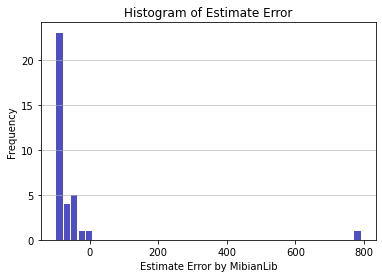

In [399]:
n, bins, patches = plt.hist(x=opt.puts['estimate_error_mb'], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Estimate Error by MibianLib')
plt.ylabel('Frequency')
plt.title('Histogram of Estimate Error')

# GREEKS

In [400]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as si

## Our put option:

In [412]:
euro_option_bsm(34.53, 32.8, 1/12, 0.0167, 0.0186, 0.3616, 'put') #Option Value

0.7032532397065108

In [426]:
S = np.linspace(20,50,55)
Call = np.zeros((len(S),1))
Put = np.zeros((len(S),1))
for i in range(len(S)):
    Put [i] = euro_option_bsm(S[i],32.8, 1/12, 0.0167, 0.0186, 0.3616, 'put')

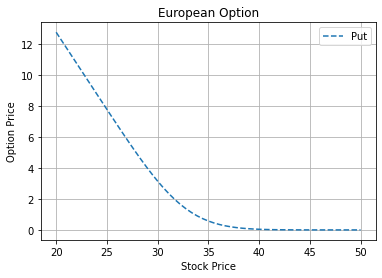

In [427]:
fig = plt.figure()

plt.plot(S, Put, '--')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.title('European Option')
plt.legend(['Put'])

## 1. DELTA

In [432]:

def delta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        delta = np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0)
    elif payoff == "put":
        delta =  - np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0)
    
    return delta

In [433]:
S = np.linspace(50, 150, 51)
T = np.linspace(0.5, 2, 51)
Delta = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Delta[i,j] = delta(S[j], 105, T[i], 0.04, 0.02, 0.3, 'put')

In [430]:
delta(34.53, 32.8, 1/12, 0.0167, 0.0186, 0.3616, 'put')

-0.2930814060664488

In [441]:
S = np.linspace(15,30,50)
Delta_Call = np.zeros((len(S),1))
Delta_Put = np.zeros((len(S),1))
for i in range(len(S)):
    Delta_Call [i] = delta(S[i], 34.5, 1, 0.0167, 0.0186, 0.3505, 'call')
    Delta_Put [i] = delta(S[i], 34.5, 1, 0.0167, 0.0186, 0.3505, 'put')

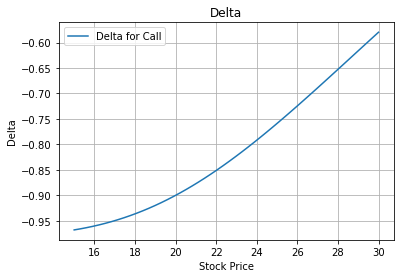

In [442]:
fig = plt.figure()
plt.plot(S, Delta_Put, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Delta')
plt.title('Delta')
plt.legend(['Delta for Call','Delta for Put'])

## 2.GAMMA

In [444]:
def gamma(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    gamma = np.exp(-r * T) * si.norm.pdf(d1, 0.0, 1.0) / (vol * S * np.sqrt(T))
    
    return gamma

In [445]:
gamma(34.53, 32.8, 1/12, 0.0167, 0.0186, 0.3616, 'put')

0.09537309416988202

In [450]:
S = np.linspace(15,30,90)
Gamma = np.zeros((len(S),1))
for i in range(len(S)):
    Gamma [i] = gamma(S[i], 32.8, 1/12, 0.0167, 0.0186, 0.3616, 'put')

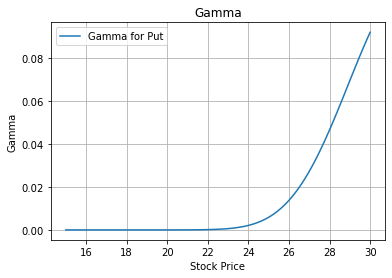

In [451]:
fig = plt.figure()
plt.plot(S, Gamma, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Gamma')
plt.title('Gamma')
plt.legend(['Gamma for Put'])

## 2.2 SPEED

In [453]:
def speed(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    speed = np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0) / ((vol **2) * (S**2) * np.sqrt(T)) * (d1 + vol * np.sqrt(T))
    
    return speed

In [454]:
speed(34.53, 32.8, 1/12, 0.0167, 0.0186, 0.3616, 'put')

0.004944825190732848

In [461]:
S = np.linspace(20,40,50)
Speed = np.zeros((len(S),1))
for i in range(len(S)):
    Speed [i] = speed(S[i], 32.8, 1/12, 0.0167, 0.0186, 0.3616, 'put')

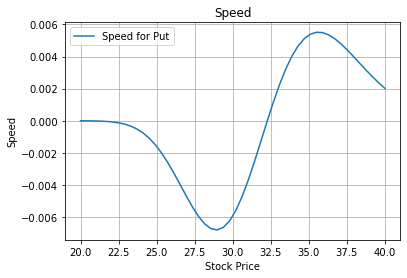

In [462]:
fig = plt.figure()
plt.plot(S, Speed, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Speed')
plt.title('Speed')
plt.legend(['Speed for Put and Call'])

## 3.THETA

In [463]:
def theta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        theta = vol * S * np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        theta = vol * S * np.exp(-q * T) * si.norm.pdf(-d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return theta

In [464]:
theta(34.53, 32.8, 1/12, 0.0167, 0.0186, 0.3616, 'put')

7.425738314253505

In [465]:
T = np.linspace(0.25,3,12)
Theta_Call = np.zeros((len(T),1))
Theta_Put = np.zeros((len(T),1))
for i in range(len(T)):
    Theta_Call [i] = theta(34.53, 32.8, T[i], 0.0167, 0.0186, 0.3616, 'call')
    Theta_Put [i] = theta(34.53, 32.8, T[i], 0.0167, 0.0186, 0.3616, 'put')

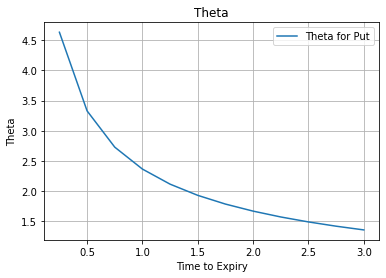

In [466]:
fig = plt.figure()

plt.plot(T, Theta_Put, '-')
plt.grid()
plt.xlabel('Time to Expiry')
plt.ylabel('Theta')
plt.title('Theta')
plt.legend([ 'Theta for Put'])

## 4.RHO

In [467]:
def rho(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        rho =  K * T * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        rho = - K * T * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return rho

In [482]:
rho(34.53, 32.8, 1/12, 0.0167, 0.0186, 0.3616, 'put')

-0.9019461825984155

In [483]:
r = np.linspace(0,2)
Rho_Call = np.zeros((len(r),1))
Rho_Put = np.zeros((len(r),1))
for i in range(len(r)):
    Rho_Call [i] = rho(34.53, 32.8, 1/12, r[i], 0.0186, 0.3616, 'call')
    Rho_Put [i] = rho(34.53, 32.8, 1/12, r[i], 0.0186, 0.3616, 'put')

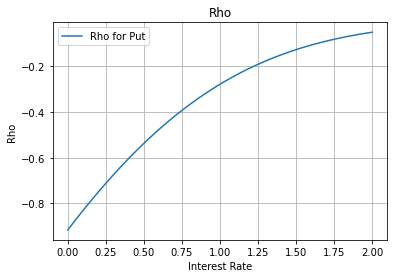

In [487]:
fig = plt.figure()
plt.plot(r, Rho_Put, '-')
plt.grid()
plt.xlabel('Interest Rate')
plt.ylabel('Rho')
plt.title('Rho')
plt.legend([ 'Rho for Put'])

## 5.VEGA

In [488]:
def vega(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    vega = S * np.sqrt(T) * np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0)
    
    return vega

In [489]:
vega(34.53, 32.8, 1/12, 0.0167, 0.0186, 0.3616, 'put')

3.4260795432145126

In [505]:
vega(34.53, 32.8, 1/12, 0.0167, 0.0186, 0.3616, 'call')

3.4260795432145126

In [514]:
vol = np.linspace(0.01,.5,5)
Vega = np.zeros((len(vol),1))
for i in range(len(vol)):
    Vega [i] = vega(34.53, 32.8, 1/12, 0.0167, 0.0186, vol[i], 'put')

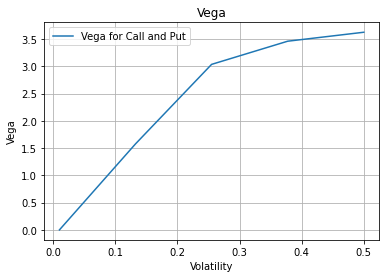

In [515]:
fig = plt.figure()
plt.plot(vol, Vega, '-')
plt.grid()
plt.xlabel('Volatility')
plt.ylabel('Vega')
plt.title('Vega')
plt.legend(['Vega for Call and Put'])

# STRATEGY ON BANK OF AMERICA 
## *Through Moving Average positions

In [529]:
initial_data = yf.download(" BAC, SPY ", start="2020-03-01", end="2021-03-01")

[*********************100%***********************]  2 of 2 completed


In [531]:
data =  initial_data['Adj Close']

In [532]:
rets = np.log(data / data.shift(1))

In [557]:
sym = 'BAC'
BAC_data = pd.DataFrame(data[sym]).dropna()


In [558]:
window = 10
BAC_data['min'] = data[sym].rolling(window=window).min()
BAC_data['mean'] = data[sym].rolling(window=window).mean()
BAC_data['std'] = data[sym].rolling(window=window).std()
BAC_data['median'] = data[sym].rolling(window=window).median()
BAC_data['max'] = data[sym].rolling(window=window).max()
BAC_data['ewma'] = data[sym].ewm(halflife=0.5, min_periods=window).mean()


In [559]:
BAC_data['SMA1'] = data[sym].rolling(window=20).mean()
BAC_data['SMA2'] = data[sym].rolling(window=60).mean()

<AxesSubplot:xlabel='Date'>

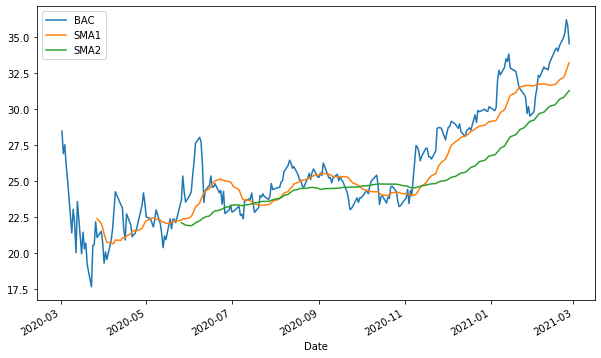

In [541]:
BAC_data[[sym, 'SMA1', 'SMA2']].plot(figsize=(10, 6))

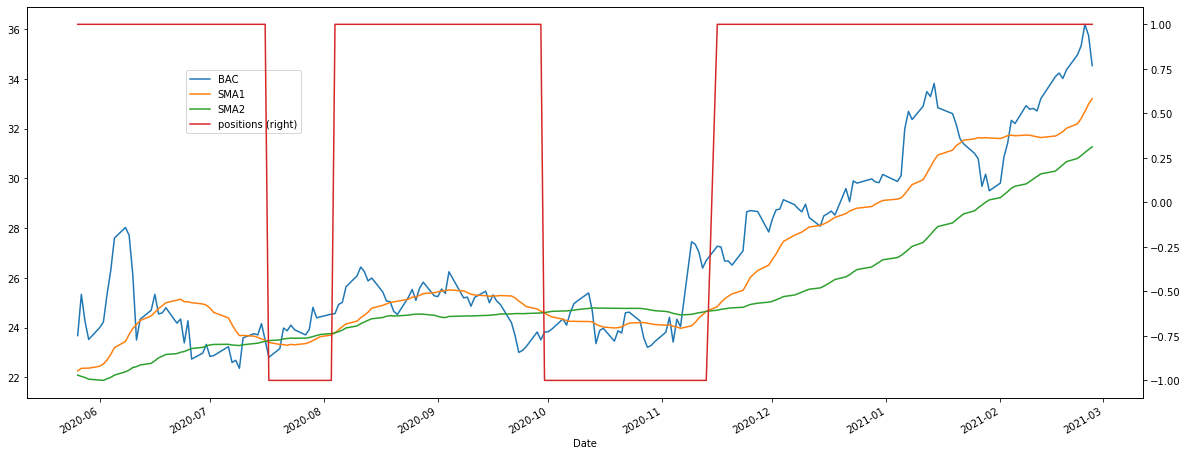

In [562]:
BAC_data.dropna(inplace=True)
BAC_data['positions'] = np.where(BAC_data['SMA1'] > BAC_data['SMA2'],1,-1)
ax = BAC_data[[sym, 'SMA1', 'SMA2', 'positions']].plot(figsize=(20, 8),secondary_y='positions')
ax.get_legend().set_bbox_to_anchor((0.25, 0.85))